In [47]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision.transforms import transforms
import numpy as np



In [48]:
# Set device to cuda 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


In [49]:
from torchvision import datasets

In [50]:
# transforms, convert to greyscale, convert to tensor, normalize and move to cuda
#import transforms

from torchvision.transforms import transforms

trainTransforms = transforms.Compose([
    # transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Lambda(lambda x: x.to(device))
])

validTransforms = transforms.Compose([
    # transforms.Resize((128, 128)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Lambda(lambda x: x.to(device))
])

In [51]:
trainFolder = 'train'
trainDataset = datasets.ImageFolder(trainFolder, transform=trainTransforms)

validFolder = 'val'
validDataset = datasets.ImageFolder(validFolder, transform=validTransforms)

In [52]:
trainDataset

Dataset ImageFolder
    Number of datapoints: 14630
    Root location: train
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
               Lambda()
           )

In [53]:
# Visualize 2 images
import matplotlib.pyplot as plt

print(trainDataset[0][0].shape)


torch.Size([1, 512, 512])


In [54]:
#Import DataLoader
from torch.utils.data import DataLoader
batchSize = 8
trainLoader = DataLoader(trainDataset, batch_size=batchSize, shuffle=True)
testLoader = DataLoader(validDataset, batch_size=batchSize, shuffle=True)   

In [55]:
print(trainLoader.dataset, testLoader.dataset)

Dataset ImageFolder
    Number of datapoints: 14630
    Root location: train
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
               Lambda()
           ) Dataset ImageFolder
    Number of datapoints: 1500
    Root location: val
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
               Lambda()
           )


In [56]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Define encoder architecture
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # define the decoder architecture
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x


In [57]:
from torchsummary import summary
model = ConvAutoEncoder().to(device)
summary(model, torch.zeros(1, 1, 512, 512))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128, 32, 32]         --
|    └─Conv2d: 2-1                       [-1, 16, 512, 512]        160
|    └─ReLU: 2-2                         [-1, 16, 512, 512]        --
|    └─MaxPool2d: 2-3                    [-1, 16, 256, 256]        --
|    └─Conv2d: 2-4                       [-1, 32, 256, 256]        4,640
|    └─ReLU: 2-5                         [-1, 32, 256, 256]        --
|    └─MaxPool2d: 2-6                    [-1, 32, 128, 128]        --
|    └─Conv2d: 2-7                       [-1, 64, 128, 128]        18,496
|    └─ReLU: 2-8                         [-1, 64, 128, 128]        --
|    └─MaxPool2d: 2-9                    [-1, 64, 64, 64]          --
|    └─Conv2d: 2-10                      [-1, 128, 64, 64]         73,856
|    └─ReLU: 2-11                        [-1, 128, 64, 64]         --
|    └─MaxPool2d: 2-12                   [-1, 128, 32, 32]         --
├─S

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128, 32, 32]         --
|    └─Conv2d: 2-1                       [-1, 16, 512, 512]        160
|    └─ReLU: 2-2                         [-1, 16, 512, 512]        --
|    └─MaxPool2d: 2-3                    [-1, 16, 256, 256]        --
|    └─Conv2d: 2-4                       [-1, 32, 256, 256]        4,640
|    └─ReLU: 2-5                         [-1, 32, 256, 256]        --
|    └─MaxPool2d: 2-6                    [-1, 32, 128, 128]        --
|    └─Conv2d: 2-7                       [-1, 64, 128, 128]        18,496
|    └─ReLU: 2-8                         [-1, 64, 128, 128]        --
|    └─MaxPool2d: 2-9                    [-1, 64, 64, 64]          --
|    └─Conv2d: 2-10                      [-1, 128, 64, 64]         73,856
|    └─ReLU: 2-11                        [-1, 128, 64, 64]         --
|    └─MaxPool2d: 2-12                   [-1, 128, 32, 32]         --
├─S

In [58]:
# Training batch
def trainBatch(input, model, criterion, optimiser):
    model.train()
    optimiser.zero_grad()
    output = model(input)
    loss = criterion(output, input)
    loss.backward()
    optimiser.step()
    return loss

In [59]:
# validation batch
@torch.no_grad()
def validBatch(input, model, criterion):
    model.eval()
    output = model(input)
    loss = criterion(output, input)
    return loss

In [60]:
model = ConvAutoEncoder().to(device)
criterion = nn.MSELoss()

# Use SGd optimizer
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)

EPOCH: 0.001  trn_loss: 0.271  (0.16s - 733.75s remaining)

EPOCH: 1.000  val_loss: 0.013  trn_loss: 0.020  (124.88s - 499.50s remaining)
EPOCH: 2.000  val_loss: 0.012  trn_loss: 0.013  (250.65s - 375.98s remaining)
EPOCH: 3.000  val_loss: 0.011  trn_loss: 0.012  (377.16s - 251.44s remaining)
EPOCH: 4.000  val_loss: 0.011  trn_loss: 0.011  (501.75s - 125.44s remaining)
EPOCH: 5.000  val_loss: 0.010  trn_loss: 0.011  (625.25s - 0.00s remaining)


100%|██████████| 106/106 [00:00<00:00, 1587.21it/s]


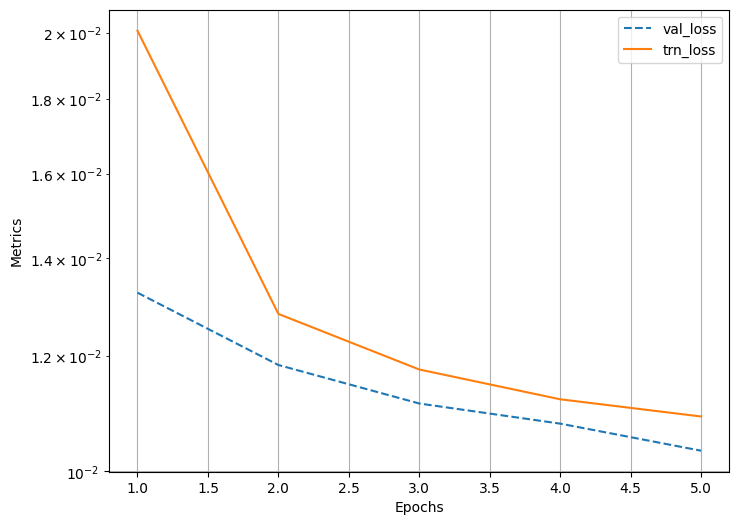

In [61]:
# Train model over increasing epochs
numEpochs = 5
# Free the memory
import gc

# report
from torch_snippets import Report
log = Report(numEpochs)

for epoch in range(numEpochs):
    N = len(trainLoader)
    
    for index,(image,label) in enumerate(trainLoader):
        loss = trainBatch(image, model, criterion, optimiser)
        log.record(pos=(epoch + (index+1)/N), trn_loss=loss,end = '\r')
    
    N = len(testLoader)
    for index,(image,label) in enumerate(testLoader):
        loss = validBatch(image, model, criterion)
        log.record(pos=(epoch + (index+1)/N), val_loss=loss,end = '\r')
        
    
    log.report_avgs(epoch+1)
log.plot_epochs(log=True)

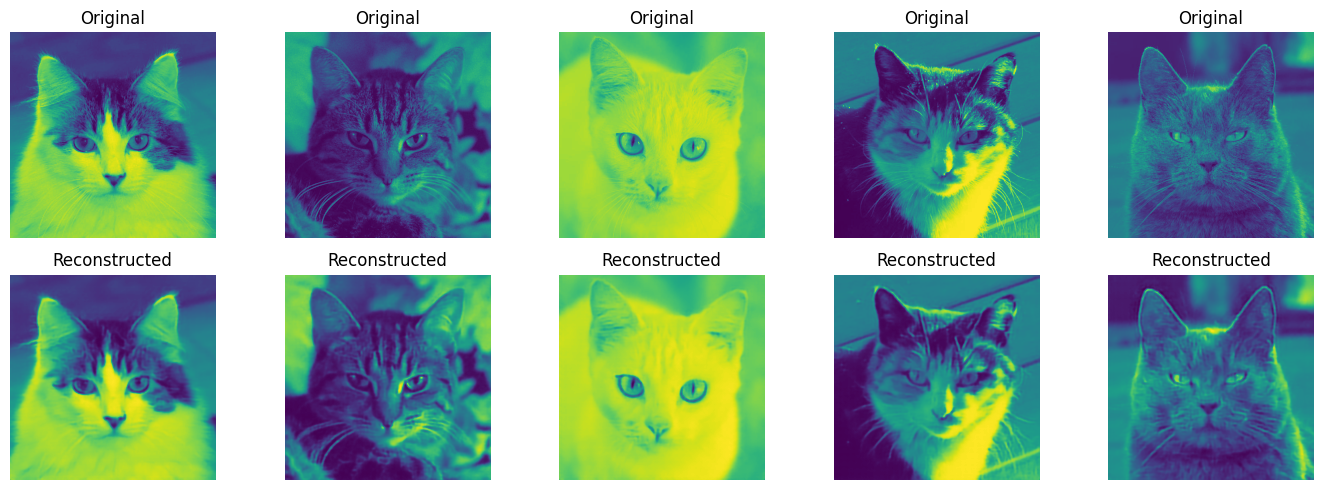

In [62]:
import matplotlib.pyplot as plt

# Create subplots with 2 rows and 5 columns, transposed
fig, axs = plt.subplots(2, 5, figsize=(14, 5))

# Iterate over 5 images in the validation set
for i in range(5):
    # Get the i-th image, transform, and send to device
    image = validDataset[i][0].unsqueeze(0)
    
    # Get the reconstructed image
    with torch.no_grad():
        reconstructed = model(image)
        
    # Plot the original image
    axs[0, i].imshow(image[0].cpu().numpy().transpose(1, 2, 0))
    axs[0, i].set_title('Original')
    
    # Plot the reconstructed image
    axs[1, i].imshow(reconstructed[0].cpu().numpy().transpose(1, 2, 0))
    axs[1, i].set_title('Reconstructed')
    
    # Remove axes
    axs[0, i].axis('off')
    axs[1, i].axis('off')

# Adjust vertical spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


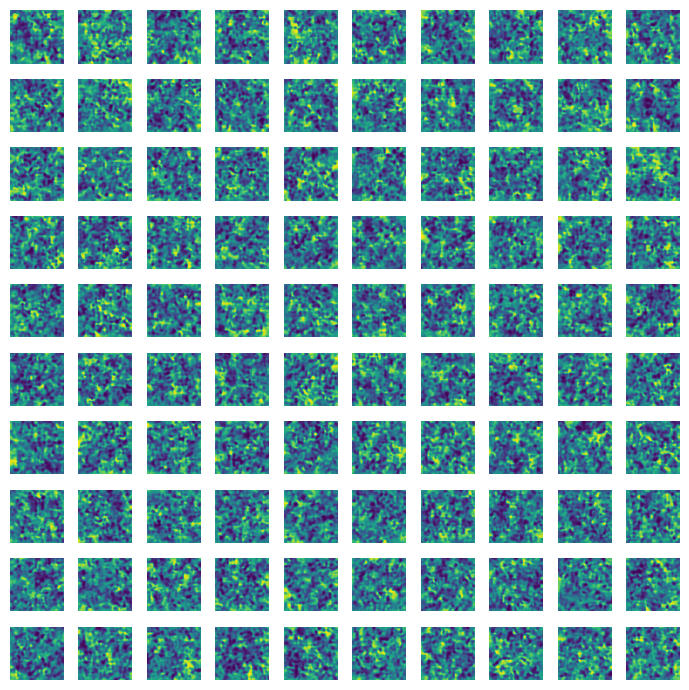

In [63]:
# Similarly generate 100 images in 10x10 grid
# Create subplots with 10 rows and 10 columns
fig, axs = plt.subplots(10, 10, figsize=(7, 7))

# Iterate over 100 images
for i in range(10):
    for j in range(10):
        # Generate random latent vector
        latent = torch.randn(1, 128, 8, 8).to(device)
        
        # Generate image from latent vector
        with torch.no_grad():
            generated = model.decoder(latent)
            
        # Plot the generated image
        axs[i, j].imshow(generated[0].cpu().numpy().transpose(1, 2, 0))
        
        # Remove axes
        axs[i, j].axis('off')
        
# Adjust vertical spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()